# Astrometric epoch propagation

This notebook demonstrates how to improve crossmatches between LSST DP1 objects and Gaia DR3 by accounting for stellar motion over time (epoch propagation).

Epoch propagation updates a source’s sky position from one observation epoch to another using its proper motion (and, when available, parallax and radial velocity). This should not be confused with the Equinox of the coordinate system: both catalogs use the ICRS frame with Equinox J2000.

Run this notebook on the Rubin Science Platform (or another environment where DP1 is available and LSDB is pre-installed). For DP1 access details, see: https://lsdb.io/dp1

We will:

- Set up the environment and define epochs for DP1 and Gaia DR3.
- Open the relevant catalogs and compute a safe search radius.
- Propagate Gaia source coordinates from the Gaia epoch to the DP1 epoch.
- Crossmatch DP1 objects with the propagated Gaia positions and select the best matches.
- Compare against a baseline crossmatch that does not use propagation.
- Visualize the difference between the two approaches.

In [1]:
import lsdb
import numpy as np
from astropy import units
from astropy.coordinates import Distance, ICRS, SkyCoord
from astropy.time import Time
from dask.distributed import Client
from upath import UPath

In [2]:
print(f"{lsdb.__version__ = }")

lsdb.__version__ = '0.7.3'


## 1. Define epochs

We specify the observation epochs for LSST DP1 (approximately late 2024) and Gaia DR3 (2016.0). These are used to translate Gaia source positions from the Gaia epoch to the DP1 epoch.

In [3]:
# DP1 was mostly October 2024, we use an approximate value here for simplicity
dp1_epoch = 2024.9
# https://gaia.aip.de/metadata/gaiadr3/
gaia_dr3_epoch = 2016.0

## 2. Open catalogs and gather configuration

Open the DP1 object catalog and retrieve its matching margin. This margin helps us decide how far to search around each DP1 source when looking for Gaia counterparts.
Here we use Rubin Science Platform path to DP1, please adjust as needed; see https://lsdb.io/dp1 for details.

In [4]:
base_path = UPath("/rubin/lsdb_data")
dp1_object = lsdb.open_catalog(
    base_path / "object_collection",
    columns=[],
)
dp1_margin_arcsec = dp1_object.margin.hc_structure.catalog_info.margin_threshold

## 3. Derive a proper-motion filter

Compute a maximum allowed proper motion based on the DP1 margin and the time difference between the two epochs. This helps us restrict Gaia sources to those that could plausibly still fall within the DP1 search area after propagation.

In [5]:
max_pm = 1000.0 * dp1_margin_arcsec / (dp1_epoch - gaia_dr3_epoch)
max_pm

561.797752808983

## 4. Load a filtered Gaia DR3 subset

Open a Gaia DR3 catalog with the columns needed for propagation and filter out entries lacking required motion or distance information. For S3 access we use MAST’s open buckets; see https://data.lsdb.io/#Gaia/Gaia_DR3_(US-East,_S3) for details.

In [6]:
gaia_dr3 = lsdb.open_catalog(
    "s3://stpubdata/gaia/gaia_dr3/public/hats",
    columns=["pmra", "pmdec", "radial_velocity", "parallax"],
    filters=[("pm", "<", max_pm), ("parallax", ">", 0.0)],
).query("radial_velocity.notna()")

## 5. Define epoch propagation

Create a helper that takes Gaia source attributes at the Gaia epoch and computes their positions at the DP1 epoch. We leverage Astropy to carry out the space‑motion propagation.

In [7]:
def propagate_epoch(df, *, start, end):
    if len(df) == 0:
        return df.assign(ra_corr=np.array([], dtype=float), dec_corr=np.array([], dtype=float))

    start_coord = SkyCoord(
        ra=df["ra"].to_numpy() * units.deg,
        dec=df["dec"].to_numpy() * units.deg,
        pm_ra_cosdec=df["pmra"].to_numpy() * units.marcsec / units.year,
        pm_dec=df["pmdec"].to_numpy() * units.marcsec / units.year,
        radial_velocity=df["radial_velocity"].to_numpy() * units.km / units.s,
        distance=Distance(parallax=df["parallax"].to_numpy() * units.marcsec),
        obstime=Time(start, format="byear"),
        frame="icrs",
    )
    end_coord = start_coord.apply_space_motion(new_obstime=Time(end, format="byear"))
    df["ra_corr"] = end_coord.ra.deg
    df["dec_corr"] = end_coord.dec.deg
    return df


propagated_gaia = gaia_dr3.map_partitions(propagate_epoch, start=gaia_dr3_epoch, end=dp1_epoch)
propagated_gaia

,pmra,pmdec,radial_velocity,parallax,ra,dec,ra_corr,dec_corr
npartitions=2016,,,,,,,,
"Order: 2, Pixel: 0",double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float64,float64
"Order: 2, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 766",...,...,...,...,...,...,...,...
"Order: 3, Pixel: 767",...,...,...,...,...,...,...,...


## 6. Crossmatch propagated Gaia to DP1 and select the best match

This is a two‑step crossmatching pipeline:

- We search with the largest radius that still preserves correct matches — the DP1 catalog’s margin defines this “safe” maximum. Using this margin ensures candidates that truly belong together are not missed.
- We intentionally keep multiple nearby Gaia candidates per DP1 object at first. After that, we compare candidates and choose the single best one using their separation. This approach lets us propagate to the target epoch and then make an informed choice among several plausible neighbors.

In [8]:
xmatch = dp1_object.crossmatch_nested(propagated_gaia, radius_arcsec=dp1_margin_arcsec, n_neighbors=20)
xmatch

,coord_ra,coord_dec,gaia
npartitions=389,,,
"Order: 6, Pixel: 130",double[pyarrow],double[pyarrow],"nested<pmra: [double], pmdec: [double], radial..."
"Order: 8, Pixel: 2176",...,...,...
...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...
"Order: 7, Pixel: 143884",...,...,...


For each DP1 object, we then choose the closest propagated Gaia candidate within a small tolerance. This reduces multiple candidates to a single best match when possible.

In [9]:
def select_best_match(dp1_ra, dp1_dec, gaia_ra, gaia_dec, *, max_dist_arcsec):
    dp1_coord = SkyCoord(ra=dp1_ra * units.deg, dec=dp1_dec * units.deg)
    gaia_coord = SkyCoord(ra=gaia_ra * units.deg, dec=gaia_dec * units.deg)
    distance = gaia_coord.separation(dp1_coord)
    idx_close = np.where(distance < max_dist_arcsec * units.arcsec)[0]
    if len(idx_close) == 0:
        return {"gaia_ra_corr": np.nan, "gaia_dec_corr": np.nan, "distance": np.nan}
    best_idx = min(idx_close, key=distance.__getitem__)
    return {
        "gaia_ra_corr": gaia_ra[best_idx],
        "gaia_dec_corr": gaia_dec[best_idx],
        "distance": distance[best_idx].to_value(units.arcsec),
    }


best_matches = (
    xmatch.map_rows(
        select_best_match,
        columns=["coord_ra", "coord_dec", "gaia.ra_corr", "gaia.dec_corr"],
        max_dist_arcsec=0.1,
        append_columns=True,
        row_container="args",
        meta=dict.fromkeys(["gaia_ra_corr", "gaia_dec_corr", "distance"], float),
    )
    .map_partitions(lambda df: df.drop(columns=["gaia"]))
    .query("distance.notna()")
)
best_matches

,coord_ra,coord_dec,gaia_ra_corr,gaia_dec_corr,distance
npartitions=389,,,,,
"Order: 6, Pixel: 130",double[pyarrow],double[pyarrow],float64,float64,float64
"Order: 8, Pixel: 2176",...,...,...,...,...
...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...


## 7. Baseline: crossmatch without propagation

As a point of comparison, perform a standard positional crossmatch using the Gaia positions at their original epoch (no propagation).

In [10]:
naive_matches = dp1_object.crossmatch(gaia_dr3, radius_arcsec=0.1, suffix_method="overlapping_columns")

## 8. Compute results with a local Dask client

All steps above are lazily evaluated. Here we actually run both pipelines — with propagation and without — and collect the results into Pandas DataFrames. We also print the number of matches from each pipeline.

In [11]:
with Client(n_workers=4, threads_per_worker=1) as client:
    display(client)
    best_matches_df = best_matches.compute()
    print(f"Propagated matches: {len(best_matches_df)}")
    naive_matches_df = naive_matches.compute()
    print(f"Non-propagated matches: {len(naive_matches_df)}")

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://malanchev.nb.data.lsst.cloud/nb/user/malanchev/proxy/8787/status,
Dashboard: https://malanchev.nb.data.lsst.cloud/nb/user/malanchev/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46535,Workers: 0
Dashboard: https://malanchev.nb.data.lsst.cloud/nb/user/malanchev/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44929,Total threads: 1
Dashboard: https://malanchev.nb.data.lsst.cloud/nb/user/malanchev/proxy/41041/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:37929,


Propagated matches: 1492


Non-propagated matches: 957


## 9. Plot separation distribution

Plot histograms of match separations for both approaches and highlight the effect of propagation. In this run, the propagated pipeline yields more matches (1492 vs 957), and the separation distribution is tighter (more matches at smaller separations).

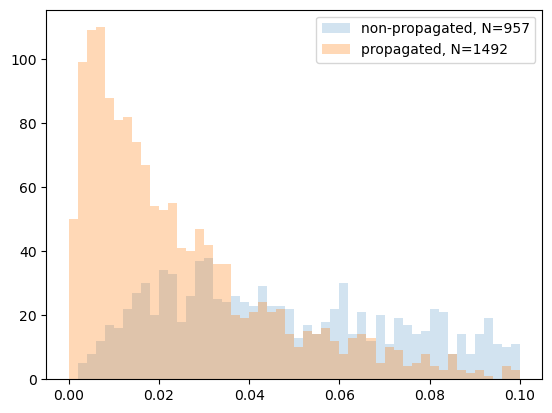

In [12]:
import matplotlib.pyplot as plt

plt.hist(
    naive_matches_df["_dist_arcsec"],
    bins=np.linspace(0, 0.1, 51),
    histtype="stepfilled",
    alpha=0.2,
    label=f"non-propagated, N={len(naive_matches_df)}",
)
plt.hist(
    best_matches_df["distance"],
    bins=np.linspace(0, 0.1, 51),
    histtype="stepfilled",
    alpha=0.3,
    label=f"propagated, N={len(best_matches_df)}",
)
plt.legend()